# Análise de Vôos com Pyspark

#### imagem 

Este notebook tem o objetivo de fazer uma análise exploratoria inicial do arquivo flights-larger.csv a fim de executar algumas transformações para responder algumas perguntas de negócio e desenvolver algumas linhas de análise.

O Spark é uma das tecnologias mais populares e fáceis para processar grandes volumes de dados. Além disso, é fácil para os iniciantes trabalharem com o Spark em comparação com outras tecnologias de computação distribuída. Então, usando a linguagem Pyspark, uma interface Python para Spark, interagiremos com o Spark.

## Primeiro passo
Primeiramente, no prompt de comando da minha máquina Windows host do projeto, digito o comando ***pyspark*** para que o mesmo já abra o jupyter e crie uma Spark Session automaticamente para meu projeto.

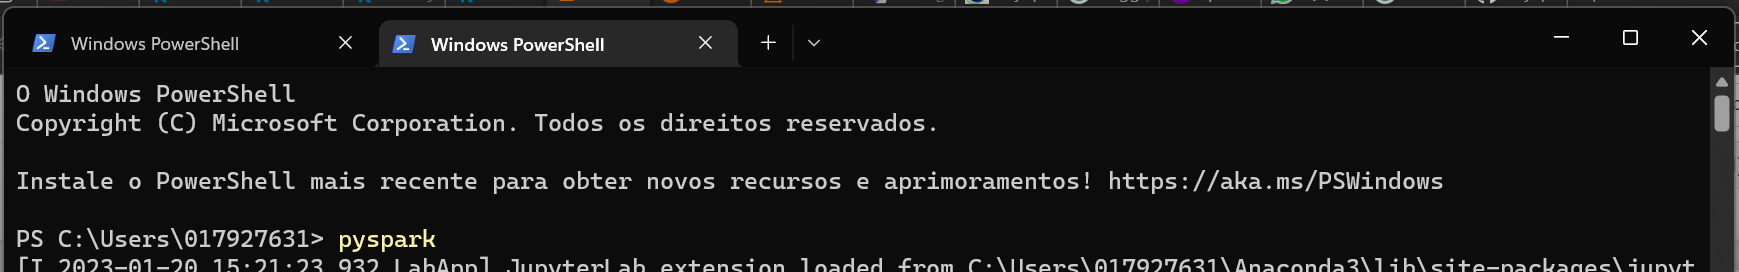

## Sobre os dados
No projeto, usarei dados sobre vôos comerciais de algumas agências aéreas do arquivo flights-larger.csv. Abaixo segue a descrição das colunas dos dados:

- **mon:** mês (inteiro entre 1 e 12)

- **dom:** dia (inteiro entre 1 e 31)

- **dow:** dia da semana (inteiro, onde: 1 é segunda-feira e 7 é domingo)

- **org:** aeroporto de origem (string que segue os códigos da Associação Internacional de Transporte Aéreo)

- **mile:** distância (inteiro na unidade de medida milhas)

- **carrier:** operadoras de transporte (string que segue os códigos da Associação Internacional de Transporte Aéreo)

- **depart:** hora de partida (double que representa hora)

- **duration:** duração esperada (inteiro que representa minutos)

- **delay:** atraso (inteiro que representa minutos)

## Importando as bibliotecas a serem utilizadas

In [255]:
import pandas as pd 
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.functions import col, when, udf, concat_ws
from pyspark.sql.types import DateType, DecimalType, IntegerType

print("---> Executado")

---> Executado


## Criando o DataFrame a partir de .CSV

In [256]:
df1 = spark.read.csv("C:/Users/017927631/Documents/PROJETOS/Pyspark_Voos/Dataset/flights-larger.csv",
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')

print("---> Executado")

---> Executado


## Análise de dados básica

### Mostrando como está a estrutura do DataFrame

In [257]:
df1.show(5)

+---+---+---+-------+------+---+----+------+--------+-----+
|mon|dom|dow|carrier|flight|org|mile|depart|duration|delay|
+---+---+---+-------+------+---+----+------+--------+-----+
| 10| 10|  1|     OO|  5836|ORD| 157|  8.18|      51|   27|
|  1|  4|  1|     OO|  5866|ORD| 466|  15.5|     102| null|
| 11| 22|  1|     OO|  6016|ORD| 738|  7.17|     127|  -19|
|  2| 14|  5|     B6|   199|JFK|2248| 21.17|     365|   60|
|  5| 25|  3|     WN|  1675|SJC| 386| 12.92|      85|   22|
+---+---+---+-------+------+---+----+------+--------+-----+
only showing top 5 rows



### Mostrando seu Schema

In [258]:
df1.printSchema()

root
 |-- mon: integer (nullable = true)
 |-- dom: integer (nullable = true)
 |-- dow: integer (nullable = true)
 |-- carrier: string (nullable = true)
 |-- flight: integer (nullable = true)
 |-- org: string (nullable = true)
 |-- mile: integer (nullable = true)
 |-- depart: double (nullable = true)
 |-- duration: integer (nullable = true)
 |-- delay: integer (nullable = true)



### Checando o tipo de dado das colunas

In [259]:
print(df1.dtypes)

[('mon', 'int'), ('dom', 'int'), ('dow', 'int'), ('carrier', 'string'), ('flight', 'int'), ('org', 'string'), ('mile', 'int'), ('depart', 'double'), ('duration', 'int'), ('delay', 'int')]


## Preparando os dados

Neste tópico farei as alterações requeridas pelo cliente e as necessárias para que consiga extrair as respostas para as perguntas de negócio. Verificar as variações de dados para ver se encontramos variações que possam ser interessantes para o cliente.

Nesta etapa iremos remover dados nulos e perdidos, e realizar as transformações e tratamentos abaixo:

1. Tratar a base converta os nomes dos campos mon para month, dom para day, dow para day_week.

2. Tratar os campos mile criando um novo campo para km e outro campo para metros.

3. Tratar o campo depart  e criar um campo colocando no padrao HH:MM.

4. Tratar o campo duration e criar um campo de horas.

5. Tratar o campo delay e criar um campo hora de delay.

Mas, também, iremos **remover os valores nulos** =)

### Tratar a base converta os nomes dos campos mon para month, dom para day, dow para day_week

In [260]:
df1 = df1.withColumnRenamed("mon", "month") \
.withColumnRenamed("dom", "day") \
.withColumnRenamed("dow", "day_week") 

df1.show(5, truncate=False)

+-----+---+--------+-------+------+---+----+------+--------+-----+
|month|day|day_week|carrier|flight|org|mile|depart|duration|delay|
+-----+---+--------+-------+------+---+----+------+--------+-----+
|10   |10 |1       |OO     |5836  |ORD|157 |8.18  |51      |27   |
|1    |4  |1       |OO     |5866  |ORD|466 |15.5  |102     |null |
|11   |22 |1       |OO     |6016  |ORD|738 |7.17  |127     |-19  |
|2    |14 |5       |B6     |199   |JFK|2248|21.17 |365     |60   |
|5    |25 |3       |WN     |1675  |SJC|386 |12.92 |85      |22   |
+-----+---+--------+-------+------+---+----+------+--------+-----+
only showing top 5 rows



### Tratar os campos mile criando um novo campo para km e outro campo para metros.

In [261]:
df2 = df1.withColumn("km", when(df1.mile > 0,round(df1.mile*1.609,2)))
df2.show(5,truncate=False)

+-----+---+--------+-------+------+---+----+------+--------+-----+-------+
|month|day|day_week|carrier|flight|org|mile|depart|duration|delay|km     |
+-----+---+--------+-------+------+---+----+------+--------+-----+-------+
|10   |10 |1       |OO     |5836  |ORD|157 |8.18  |51      |27   |252.61 |
|1    |4  |1       |OO     |5866  |ORD|466 |15.5  |102     |null |749.79 |
|11   |22 |1       |OO     |6016  |ORD|738 |7.17  |127     |-19  |1187.44|
|2    |14 |5       |B6     |199   |JFK|2248|21.17 |365     |60   |3617.03|
|5    |25 |3       |WN     |1675  |SJC|386 |12.92 |85      |22   |621.07 |
+-----+---+--------+-------+------+---+----+------+--------+-----+-------+
only showing top 5 rows



In [262]:
df2 = df2.withColumn("m", when(df1.mile > 0,round(df1.mile*1609,2)))
df2.show(5,truncate=False)

+-----+---+--------+-------+------+---+----+------+--------+-----+-------+-------+
|month|day|day_week|carrier|flight|org|mile|depart|duration|delay|km     |m      |
+-----+---+--------+-------+------+---+----+------+--------+-----+-------+-------+
|10   |10 |1       |OO     |5836  |ORD|157 |8.18  |51      |27   |252.61 |252613 |
|1    |4  |1       |OO     |5866  |ORD|466 |15.5  |102     |null |749.79 |749794 |
|11   |22 |1       |OO     |6016  |ORD|738 |7.17  |127     |-19  |1187.44|1187442|
|2    |14 |5       |B6     |199   |JFK|2248|21.17 |365     |60   |3617.03|3617032|
|5    |25 |3       |WN     |1675  |SJC|386 |12.92 |85      |22   |621.07 |621074 |
+-----+---+--------+-------+------+---+----+------+--------+-----+-------+-------+
only showing top 5 rows



### Tratar o campo depart e criar um campo colocando no padrao HH:MM.

In [267]:
df3 = df2.withColumn('hours',
     split(f.col("depart"), "[\.]", -1)[0]
   ).withColumn('minuts',
     split(f.col("depart"), "[\.]", -1)[1]
   )

df3.show()

+-----+---+--------+-------+------+---+----+------+--------+-----+-------+-------+-----+------+
|month|day|day_week|carrier|flight|org|mile|depart|duration|delay|     km|      m|hours|minuts|
+-----+---+--------+-------+------+---+----+------+--------+-----+-------+-------+-----+------+
|   10| 10|       1|     OO|  5836|ORD| 157|  8.18|      51|   27| 252.61| 252613|    8|    18|
|    1|  4|       1|     OO|  5866|ORD| 466|  15.5|     102| null| 749.79| 749794|   15|     5|
|   11| 22|       1|     OO|  6016|ORD| 738|  7.17|     127|  -19|1187.44|1187442|    7|    17|
|    2| 14|       5|     B6|   199|JFK|2248| 21.17|     365|   60|3617.03|3617032|   21|    17|
|    5| 25|       3|     WN|  1675|SJC| 386| 12.92|      85|   22| 621.07| 621074|   12|    92|
|    3| 28|       1|     B6|   377|LGA|1076| 13.33|     182|   70|1731.28|1731284|   13|    33|
|    5| 28|       6|     B6|   904|ORD| 740|  9.58|     130|   47|1190.66|1190660|    9|    58|
|    1| 19|       2|     UA|   820|SFO| 

In [264]:
#@f.udf(DecimalType())
#    def t_hours(hours,minuts):
#        a = round(f.col('hours') + f.col('minuts') / 60, 2)
#        
#        return a

In [268]:
df3 = df3.withColumn("min", (round(f.col('minuts') * 0.60, 0).cast(IntegerType())))
df3 = df3.drop("minuts")
df3.show()

+-----+---+--------+-------+------+---+----+------+--------+-----+-------+-------+-----+---+
|month|day|day_week|carrier|flight|org|mile|depart|duration|delay|     km|      m|hours|min|
+-----+---+--------+-------+------+---+----+------+--------+-----+-------+-------+-----+---+
|   10| 10|       1|     OO|  5836|ORD| 157|  8.18|      51|   27| 252.61| 252613|    8| 11|
|    1|  4|       1|     OO|  5866|ORD| 466|  15.5|     102| null| 749.79| 749794|   15|  3|
|   11| 22|       1|     OO|  6016|ORD| 738|  7.17|     127|  -19|1187.44|1187442|    7| 10|
|    2| 14|       5|     B6|   199|JFK|2248| 21.17|     365|   60|3617.03|3617032|   21| 10|
|    5| 25|       3|     WN|  1675|SJC| 386| 12.92|      85|   22| 621.07| 621074|   12| 55|
|    3| 28|       1|     B6|   377|LGA|1076| 13.33|     182|   70|1731.28|1731284|   13| 20|
|    5| 28|       6|     B6|   904|ORD| 740|  9.58|     130|   47|1190.66|1190660|    9| 35|
|    1| 19|       2|     UA|   820|SFO| 679| 12.75|     123|  135|1092

In [272]:
df3 = df3.withColumn('hour_min', concat_ws(':',df3.hours,df3.min))

df3.show()

+-----+---+--------+-------+------+---+----+------+--------+-----+-------+-------+-----+---+--------+
|month|day|day_week|carrier|flight|org|mile|depart|duration|delay|     km|      m|hours|min|hour_min|
+-----+---+--------+-------+------+---+----+------+--------+-----+-------+-------+-----+---+--------+
|   10| 10|       1|     OO|  5836|ORD| 157|  8.18|      51|   27| 252.61| 252613|    8| 11|    8:11|
|    1|  4|       1|     OO|  5866|ORD| 466|  15.5|     102| null| 749.79| 749794|   15|  3|    15:3|
|   11| 22|       1|     OO|  6016|ORD| 738|  7.17|     127|  -19|1187.44|1187442|    7| 10|    7:10|
|    2| 14|       5|     B6|   199|JFK|2248| 21.17|     365|   60|3617.03|3617032|   21| 10|   21:10|
|    5| 25|       3|     WN|  1675|SJC| 386| 12.92|      85|   22| 621.07| 621074|   12| 55|   12:55|
|    3| 28|       1|     B6|   377|LGA|1076| 13.33|     182|   70|1731.28|1731284|   13| 20|   13:20|
|    5| 28|       6|     B6|   904|ORD| 740|  9.58|     130|   47|1190.66|1190660|